<a id = '0'></a>
<p style = "font-size : 30px; color : white ; text-align : center; background-color : Green; border-radius: 5px 5px; padding : 10px"><strong>Хакатон от Сбера "Красивый код"</strong></p> 

<h1 style="text-align: center;">Условия задания</h1>

Постройте наилучшую модель, которая на основании размеченных данных будет предсказывать качество пароля, введенного пользователем.   
Данные состоят из примеров паролей и их оценок: 0 (слабый), 1 (средний) и 2 (сильный).

Дополнительные требования:

Предусмотреть возможность проверки новых паролей.  
Прокомментировать и обосновать преобразования данных, выбор метода и метрики для оценивания результата предсказания модели.

<h1 style="text-align: center;">Загрузка пакетов</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model #линейные модели
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

<h1 style="text-align: center;">Данные их структура</h1>

In [2]:
pas = pd.read_csv('passwords.csv')
pas.head()

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2


In [3]:
pas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  100000 non-null  object
 1   strength  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [4]:
print(pas['password'].nunique())
print(pas['strength'].unique())

100000
[1 2 0]


<Axes: xlabel='strength', ylabel='count'>

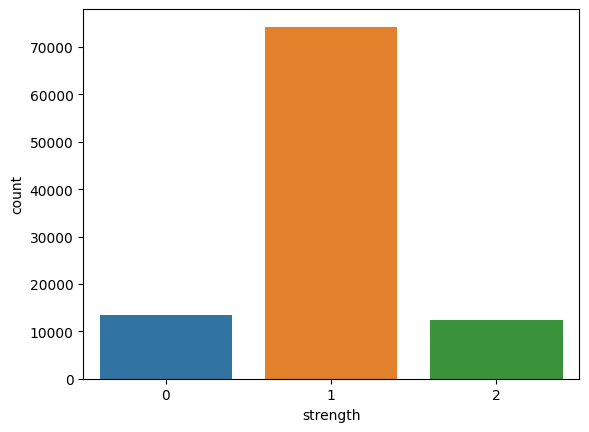

In [5]:
sns.countplot(data=pas, x='strength')

Данные представлены двумя признаками:  
* password - сами пароли; 100 000 не пустых уникальных строковых значений
* strength - категория пароля: 0, 1, 2; 100 000 не пустых числовых значений
* наблюдается явный дисбаланс классов

<h1 style="text-align: center;">Классификация</h1>

В исходных данных целевой признак является категориальным - з класса сложности паролей.  
Необходимо предсказать класс сложности новых паролей на основе имеющихся размеченных данных.  
Данная задача относится к виду обучения - *обучение с учителем*, типу обучения - *мультиклассовая классификация*.  
**Цель** — построить модель, которая на основе признаков разделяет объекты на классы наилучшим образом.  
Для решения задачи будет использована **логистическая регрессия (Logistic Regression)** поскольку данный метод обладает интерпритируемыми метриками качества модели, не требует большого количества ресурсов для произведения вычислений, а так же подбора гиперпараметров для модели.

<h2 style="text-align: center;">Базовая модель</h2>

In [6]:
X = pas.drop(['strength'], axis = 1)                                 # зададим признак для обучения модели 
y = pas['strength']                                                  # выделим целевую переменую
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,       # стратифицированое разбиение для избежания дисбаланса классов в тренировочной и тестовой выборках
                                                    test_size = 0.2,   # разделим выборку на тренировочную и тестовую в соотношении 80/20
                                                    random_state=42)  # Устанавливаем random_state для воспроизводимости результатов 

#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)   
print('Test:', X_test.shape, y_test.shape)

Train: (80000, 1) (80000,)
Test: (20000, 1) (20000,)


In [7]:
# Преобразование текстовых данных в матрицу TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['password'])     # tfidf_vectorizer.fit_transform принимает только 1 столбец на вход за раз, по-этому зададим непосредственно признак
X_test_tfidf = tfidf_vectorizer.transform(X_test['password'])

log_reg_base = linear_model.LogisticRegression(                              # Создаём объект класса LogisticRegression
                                               multi_class='multinomial',    #мультиклассовая классификация
                                               max_iter=1000,                #количество итераций, выделенных на сходимость
                                               random_state=42               #генерация случайных чисел
                                                )         
log_reg_base.fit(X_train_tfidf, y_train)                                # Обучаем модель на тренировочных данных, которые составляют 70% от выборки

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

Посмотрим на метрики модели.

Text(33.22222222222222, 0.5, 'y true')

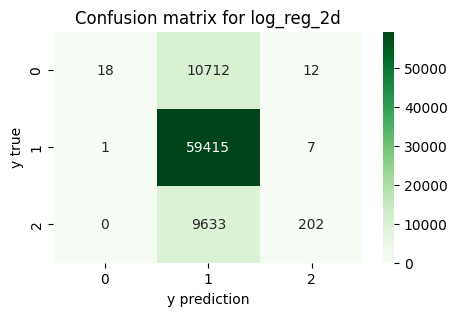

In [8]:
y_pred_train_base = log_reg_base.predict(X_train_tfidf)                          # получаем предсказание для тренировочных данных
confusion_matrix_base = metrics.confusion_matrix(y_train, y_pred_train_base)     # Строим матрицу ошибок

#Визуализируем матрицу ошибок
fig, axes = plt.subplots(1, 1, figsize=(5, 3))                                   # фигура координатная плоскость
sns.heatmap(confusion_matrix_base, annot=True, fmt='', ax=axes, cmap='Greens')    # Строим тепловую карту для первой матрицы ошибок

#Добавляем название графику и подписи осей абсцисс и ординат
axes.set_title('Confusion matrix for log_reg_2d')
axes.set_xlabel('y prediction')
axes.set_ylabel('y true')

In [9]:
report_base = classification_report(y_train, y_pred_train_base)  # Создание отчета о классификации
print(report_base)                                               # Вывод отчета

              precision    recall  f1-score   support

           0       0.95      0.00      0.00     10742
           1       0.74      1.00      0.85     59423
           2       0.91      0.02      0.04      9835

    accuracy                           0.75     80000
   macro avg       0.87      0.34      0.30     80000
weighted avg       0.79      0.75      0.64     80000



**Интерпретация метрик:**
* в целом модель не плохо определяет пароли класса 1, но это скорее всего связано с наличием дисбаланса в выборках;    
* что касается классов 0 и 2, при получении новых данных, модель с большой вероятностью классифицирует их не верно и отнесет к классу 1.
* метрика accuracy не будет учитываться, поскольку наблюдается явный дисбаланс в классах.

Поскольку для решения задачи в приоретете распознать не надежные пароли, ориентироваться будем на метрику recall, а она говорит нам о том, что ни 0, ни 2 классы модель определять не научилась.

<h2 style="text-align: center;">Оптимальная модель</h2>

Национальный институт стандартов и технологий (США) (NIST) для оценки энтропии пароля, созданного человеком и не включающего символы из неанглийских алфавитов, предлагает использовать следующий алгоритм:

* энтропия первого символа принимается равной 4 битам;
* энтропия следующих семи символов принимается равной по 2 бита на каждый символ;
* энтропия символов от 9-го до 20-го принимается равной по 1,5 бита на каждый символ;
* энтропия символов от 21-го и последующих принимается равной 1 биту на каждый символ;
* энтропия пароля принимается равной сумме энтропий символов;
* если в пароле используются заглавные буквы и неалфавитные символы, то к сумме прибавляется ещё 6 бит.

Используем данный алгоритм для подсчета энтропии пароля.

In [10]:
pas1 = pas.copy()   # создадим копию датасета, что бы не потерять первоначальные данные при преобразовании

In [11]:
# введем коэффициенты

w2_8 = 2       # энтропия символов со 2 по 8 символы
w9_20 = 1.5    # энтропия символов с 9 по 20 символы
w21 = 1        # энтропия символов с 21 символа
w_s = 6        # дополнительная энтропия за использование заглавных букв и неалфовитных символов

In [12]:
# Функция для вычисления энтропии пароля
def entropy_func(row, column_name):                                                                              # на вход будем принимать строку датасета и итерироваться по выбранному признаку
    if not any(c.isalnum() for c in row[column_name]):                                                           # добавим дополнительное условие, если пароль состоит только из символов
        return 0                                                                                                 # присваеваем энторпию = 0, в противном случае
    else:
        if len(row[column_name]) <= 8 and not any(c.isupper() and c.isalnum() for c in row[column_name]):        # если длина пароля <= 8 символов и он состоит только из букв и цифр
            return 4 + (len(row[column_name]) - 1) * w2_8                                                        # энтропия будет равна 4 + (длина пароля - 1) * 2
        elif len(row[column_name]) <= 8 and any(c.isupper() or not c.isalnum() for c in row[column_name]):       # если длина пароля <= 8 и содержит заглавные буквы или неалфовитные символы
            return 4 + (len(row[column_name]) - 1) * w2_8 + w_s                                                  # энтропия будет равна 4 + (длина пароля - 1) * 2 + 6
        elif 8 < len(row[column_name]) <= 20 and not any(c.isupper() and c.isalnum() for c in row[column_name]): # если длина пароля <= 20 символам и он состоит только из букв и цифр
            return 4 + 7 * w2_8 + (len(row[column_name]) - 8) * w9_20                                            # энтропия будет равна 4 + 7 * 2 + (длина пароля - 8)*1,5
        elif 8 < len(row[column_name]) <= 20 and any(c.isupper() or not c.isalnum() for c in row[column_name]):  # если длина пароля <= 20 и содержит заглавные буквы или неалфовитные символы
            return 4 + 7 * w2_8 + (len(row[column_name]) - 8) * w9_20 + w_s                                      # энтропия будет равна 4 + 7 * 2 + (длина пароля - 8)*1,5 + 6
        elif len(row[column_name]) > 20 and not any(c.isupper() and c.isalnum() for c in row[column_name]):      # если длина пароля > 20 символов и он состоит только из букв и цифр
            return 4 + 7 * w2_8 + 12 * w9_20 + len(row[column_name]) - 20                                        # энтропия будет равна 4 + 7 * 2 + 12*1,5 + длина пароля - 20
        elif len(row[column_name]) > 20 and any(c.isupper() or not c.isalnum() for c in row[column_name]):       # если длина пароля > 20 и содержит заглавные буквы или неалфовитные символы
            return 4 + 7 * w2_8 + 12 * w9_20 + len(row[column_name]) - 20 + w_s                                  # энтропия будет равна 4 + 7 * 2 + 12*1,5 + длина пароля - 20 + 6
        else:
            return None

In [13]:
column_name = 'password'                                            # указываем имя столбца, который будем использовать 

def assign_entropy_funk(row):                                       # создадим вспомогаельную функцию assign_entropy_funk(), которая будет принимать на вход строку датасета
    return entropy_func(row, column_name)                           # затем вызывать функцию entropy_func() и вместе со строкой передавать ей выбранный признак

pas1 = pas1.assign(entropy=pas1.apply(assign_entropy_funk,          # создадим новый признак "entropy" с помощью функции assign_entropy_funk()
                                      axis=1))                      # для того, что бы избежать выхода предупреждений от pandas о попытке изменить данные, применим метод assign
pas1.head()                                                         # посмотрим на результат работы функции assign_entropy_funk()

,password,strength,entropy
0,yrtzuab476,1,21.0
1,yEdnN9jc1NgzkkBP,2,36.0
2,sarita99,1,18.0
3,Suramerica2015,2,33.0
4,PPRbMvDIxMQ19TMo,2,36.0


In [14]:
sum(np.isnan(pas1['entropy']))  # посмотрим есть ли в результате работы функции пропущенные значения

0

Обучим модель на данных энтропии

In [15]:
X_ent = pas1.drop(['password', 'strength'], axis = 1)                        # зададим новую переменную для признака для обучения модели 
y = pas1['strength']                                                         # выделим целевую переменую
X_train_ent, X_test_ent, y_train, y_test = train_test_split(X_ent, 
                                                            y, 
                                                            stratify=y,       # стратифицированое разбиение для избежания дисбаланса классов в тренировочной и тестовой выборках
                                                            test_size = 0.2,  # разделим выборку на тренировочную и тестовую в соотношении 80/20
                                                            random_state=42)  # Устанавливаем random_state для воспроизводимости результатов 

#Выводим результирующие размеры таблиц
print('Train:', X_train_ent.shape, y_train.shape)   
print('Test:', X_test_ent.shape, y_test.shape)

Train: (80000, 1) (80000,)
Test: (20000, 1) (20000,)


In [16]:
log_reg_ent = linear_model.LogisticRegression(                              # Создаём объект класса LogisticRegression
                                               multi_class='multinomial',    #мультиклассовая классификация
                                               max_iter=1000,                #количество итераций, выделенных на сходимость
                                               random_state=42               #генерация случайных чисел
                                                )      
log_reg_ent.fit(X_train_ent, y_train)                                  # Обучаем модель на тренировочных данных, которые являются числовыми и не требуют векторизации

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

Выводим метрики

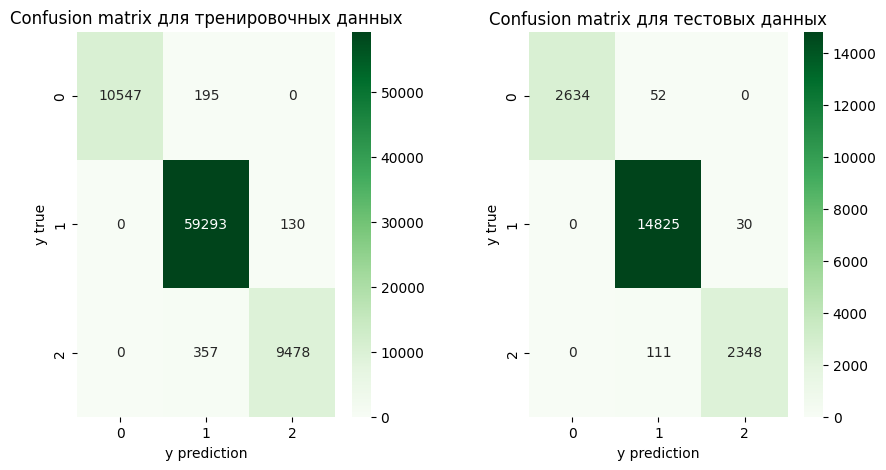

In [17]:
y_pred_train_ent = log_reg_ent.predict(X_train_ent)                             # получаем предсказание для тренировочных данных
y_pred_test_ent = log_reg_ent.predict(X_test_ent)                               # получаем предсказание для тестовых данных
confusion_matrix_ent1 = metrics.confusion_matrix(y_train, y_pred_train_ent)     # Строим матрицу ошибок для тренировочных данных
confusion_matrix_ent2 = metrics.confusion_matrix(y_test, y_pred_test_ent)      # Строим матрицу ошибок для тестовых данных

#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(10, 5))                                      # фигура координатная плоскость
sns.heatmap(confusion_matrix_ent1, annot=True, fmt='', ax=axes[0], cmap='Greens')    # Строим тепловую карту для первой матрицы ошибок

#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix для тренировочных данных')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')

sns.heatmap(confusion_matrix_ent2, annot=True, fmt='', ax=axes[1], cmap='Greens')    # Строим тепловую карту для второй матрицы ошибок

#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix для тестовых данных')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true')

plt.subplots_adjust(wspace=0.4)

In [18]:
report_train_ent = classification_report(y_train, y_pred_train_ent)  # Создание отчета о классификации для тренировочных данных
print(report_train_ent)                                               # Вывод отчета

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10742
           1       0.99      1.00      0.99     59423
           2       0.99      0.96      0.97      9835

    accuracy                           0.99     80000
   macro avg       0.99      0.98      0.99     80000
weighted avg       0.99      0.99      0.99     80000



In [19]:
report_test_ent = classification_report(y_test, y_pred_test_ent)  # Создание отчета о классификации для тренировочных данных
print(report_test_ent)                                               # Вывод отчета

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2686
           1       0.99      1.00      0.99     14855
           2       0.99      0.95      0.97      2459

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.98     20000
weighted avg       0.99      0.99      0.99     20000



**Интерпретация метрик**  
1. Исходя из данных отчета classification_report() поведение модели как на тренировчных, так и на тестовых данных не отличается, соответтсвенно переобучение модели отсутствует и не требует регуляризации.
2. Метрика recall показывает, что минимум 95% паролей будут отнесены к нужному классу. При отсутствии в бизнес - требованиях порога метрики, данный результат можно считать удовлетворительным.

<h1 style="text-align: center;">Проверка новых паролей</h1>

In [20]:
new_passwords = input('Введите пароль для проверки: ')                                         # предусмотрим ввод нового пароля
new_passwords = pd.DataFrame({'new_password': [new_passwords]})                                # преобразуем в форму датасета

column_name = 'new_password'                                                                   # укажем имя признака для функции entropy_func()

def assign_entropy_funk(row):                                                                  # применим функцию assign_entropy_funk() к новому паролю
    return entropy_func(row, column_name)                           
new_passwords = new_passwords.assign(entropy=new_passwords.apply(assign_entropy_funk, axis=1)) 

Введите пароль для проверки:  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [21]:
categories = ["слабый", "средний", "сильный"]                                         # зададим список названий категорий
labels = [0, 1, 2]                                                                    # зададим список классов категорий

y_new_pred = log_reg_ent.predict(new_passwords.drop('new_password', axis = 1))        # подадим новый пароль обученной модели для предсказания его категории

# Интерпретируем и выведем результаты
predicted_categories = [categories[label] for label in y_new_pred]                    # для каждого класса 'label' получаем соответствующую категорию из списка категорий 'categories' и                                                                                               записываем в список 'predicted_categories' 
for password, category in zip(new_passwords['new_password'], predicted_categories):   # для каждой пары элементов new_passwords['password'] и 'predicted_categories'
    print(f"Пароль '{password}' классифицируется как: '{category}'")                  # выводим на печать пароль и присвоенную категорию пароля

Пароль '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!' классифицируется как: 'слабый'


**Испольнитель**: Лин Светлана Сергеевна    
**Телеграмм**: @SS_Lin

Фиксирование используемых пакетов

In [22]:
pip freeze

aiofiles==23.1.0
aiogram==2.15
aiohttp==3.8.5
aiosignal==1.3.1
anaconda-client==1.12.0
anaconda-navigator==2.4.2
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
annotated-types==0.5.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
async-lru==2.0.3
async-timeout==4.0.3
attrs @ file:///C:/b/abs_09s3y775ra/croot/attrs_1668696195628/work
Babel==2.12.1
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/work
backports.tempfile @ file:///home/linux1/recipes/ci/backports.tempfile_1610991236607/work
backports.weakref==1.0.post1
beautifulsoup4 @ file:///C:/b/abs_0agyz1wsr4/croot/beautifulsoup4-split_1681493048687/work
bleach==6.0.0
boltons @ file:///C:/b/abs_707eo7c09t/croot/boltons_1677628723117/work
Bottlenec